In [1]:
import os
import sys
par_dir = os.path.dirname(os.path.realpath("."))
sys.path.append(os.path.join(par_dir))
import pandas as pd
import numpy as np
from utils import get_inds, draw_concept_by_order_pos_neg_andor, get_masks
import os.path as osp
import json
%matplotlib inline

## BERT-Base VS. BERT-Large on SST2

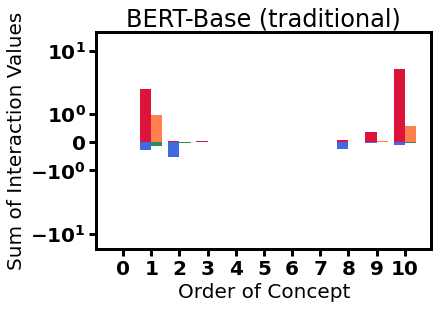

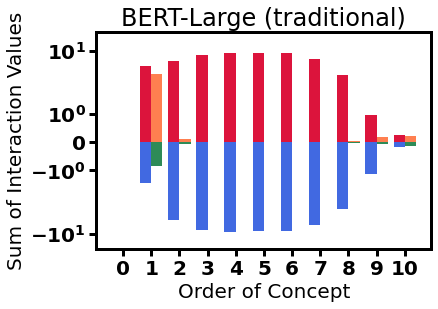

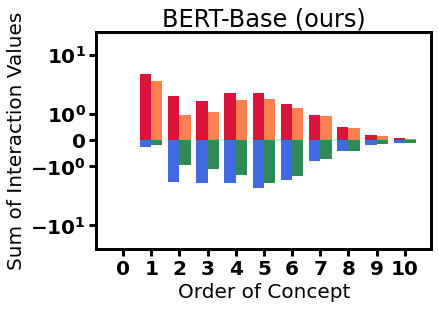

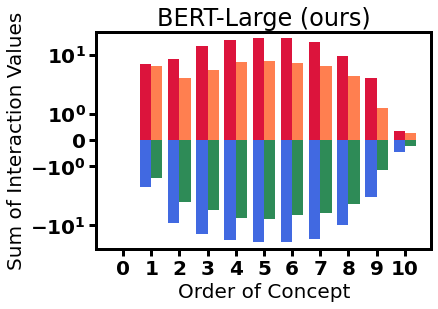

In [2]:
model_names = ['base', 'large'] 
model_name_print = ['BERT-Base', 'BERT-Large']
data_path = json.load(open('outputPaths_sst2.json', 'r'))

# define data path
DataPaths = {
    'base': data_path["disjoint"]["bert-base"],
    'large': data_path["disjoint"]["bert-large"],
    'joint_base_large_05': data_path["joint"]
}

inds = sorted(get_inds(DataPaths['joint_base_large_05']))[:200]
epsilon = '05'  
num_players = 10  
masks = get_masks(num_players)

model_thresholds = {}
sample_dirs = [DataPaths[model_names[0]], DataPaths[model_names[1]]]

threshold = pd.read_csv("/data1/cl/distillation/output/Vn_Vempty_baseline913.csv") # calculated from joint case #TODO datapath should be handled
model_thresholds[model_names[0]] = np.mean(threshold['base']) 
model_thresholds[model_names[1]] = np.mean(threshold['large'])

# joint
joint_path = DataPaths[f'joint_{model_names[0]}_{model_names[1]}_{epsilon}']

draw_concept_by_order_pos_neg_andor(inds, 'individual_learning', sample_dirs, masks, model_names,model_name_print, vmax=23.5, vmin=-20.5,cnt=False, model_thresholds=model_thresholds)
draw_concept_by_order_pos_neg_andor(inds, 'joint_learning_base-large', joint_path, masks, model_names,
                                    model_name_print, vmax=30.5, vmin=-32.5,cnt=False, model_thresholds=model_thresholds)


## LlaMa VS. OPT-1.3B on SQuAD

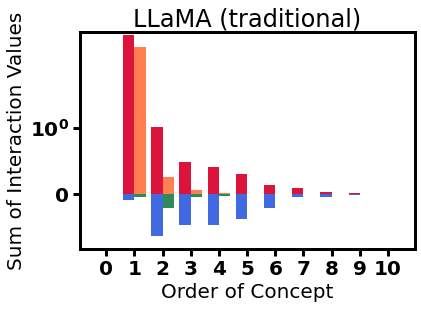

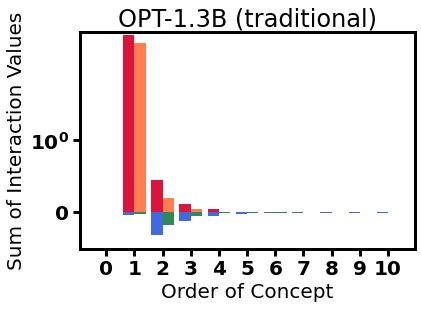

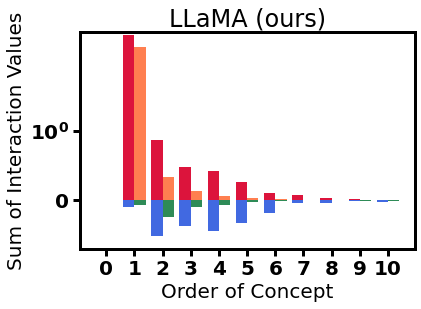

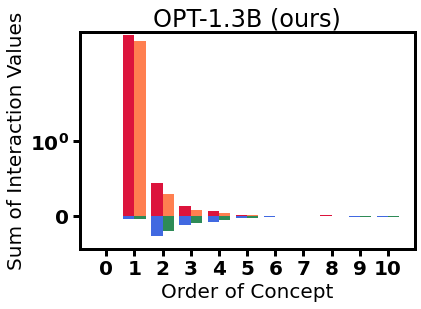

In [3]:
model_names = ['llama', 'opt']  # 模型名称
model_name_print = ['LLaMA', 'OPT-1.3B']
data_path = json.load(open('outputPaths_squad.json', 'r'))


DataPaths = {
    'llama': data_path["disjoint"]["llama"],
    'opt': data_path["disjoint"]["opt"],
    'joint_llama_opt_05': data_path["joint"]
}  


inds = get_inds(DataPaths['joint_llama_opt_05'], dataset="squad")[:200]
epsilon = '05'  
num_players = 10 
masks = get_masks(num_players)

model_thresholds = {}

# individual
sample_dirs = [DataPaths[model_names[0]], DataPaths[model_names[1]]]
for sample_dir in sample_dirs:
    list_of_vn_vempty = []
    for ind in inds:
        if osp.exists(sample_dir + f"/sample-{int(ind)}"):
            rewards = np.load(osp.join(sample_dir, f'sample-{int(ind)}', 'rewards.npy'))
        else:
            rewards = np.load(osp.join(sample_dir, f'sample{int(ind)}', 'rewards.npy'))
        VN_Vempty = np.abs(rewards[-1] - rewards[0])
        list_of_vn_vempty.append(VN_Vempty)
    model_threshold = np.mean(list_of_vn_vempty)
    model_thresholds[sample_dir] = model_threshold

# joint
joint_path = DataPaths[f'joint_{model_names[0]}_{model_names[1]}_{epsilon}']
sample_dir = joint_path
for model_type in model_names:
    list_of_vn_vempty = []
    for ind in inds:
        if osp.exists(sample_dir + f"/sample-{int(ind)}"):
            rewards = np.load(osp.join(sample_dir, f'sample-{int(ind)}', model_type, 'rewards.npy'))
        else:
            rewards = np.load(osp.join(sample_dir, f'sample{int(ind)}', model_type, 'rewards.npy'))
        VN_Vempty = np.abs(rewards[-1] - rewards[0])
        list_of_vn_vempty.append(VN_Vempty)
    model_threshold = np.mean(list_of_vn_vempty)
    model_thresholds[model_type] = model_threshold

draw_concept_by_order_pos_neg_andor(inds,'individual_learning', sample_dirs, masks, model_names, model_name_print, vmax=None, vmin=None,cnt=False, dataset="squad", model_thresholds=model_thresholds)
draw_concept_by_order_pos_neg_andor(inds, 'joint_learning_llama-aquila', joint_path, masks, model_names, model_name_print, vmax=None, vmin=None,cnt=False, dataset="squad", model_thresholds=model_thresholds)

## ResNet-20 VS. VGG-16 on MNIST

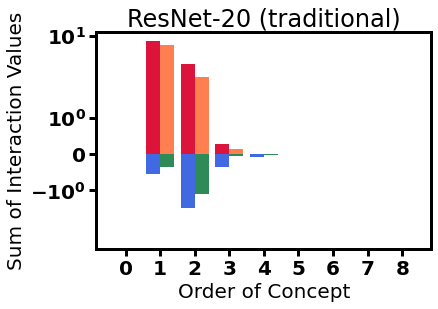

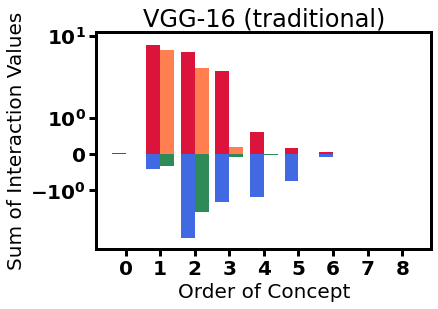

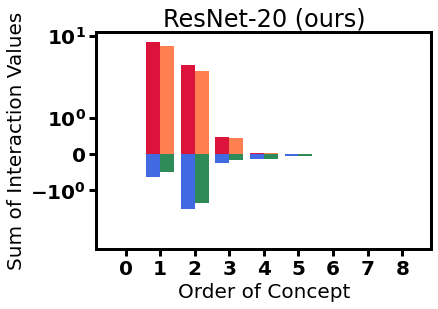

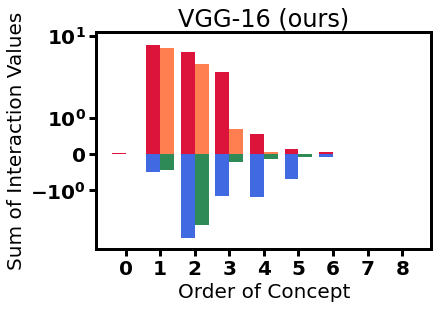

In [4]:
import torch
import os
model_names = ['resnet20', 'vgg16']  
model_name_print = ['ResNet-20', 'VGG-16']
data_path = json.load(open('outputPaths_mnist.json', 'r'))

# define data path
DataPaths = {
    'resnet20': data_path["disjoint"]["resnet20"],
    'vgg16': data_path["disjoint"]["vgg16"],
    'joint_resnet20_vgg16_05': data_path["joint"]
}  

inds = get_inds(DataPaths['joint_resnet20_vgg16_05'], "mnist")[:200]
epsilon = '05'  
num_players = 8  # number of players
masks = get_masks(num_players)

model_thresholds = {}

# individual
sample_dirs = [DataPaths[model_names[0]], DataPaths[model_names[1]]]

# joint
joint_path = DataPaths[f'joint_{model_names[0]}_{model_names[1]}_{epsilon}']

path = '/data1/cl/distillation/output/image-manual-segment/dataset=simpleisthree_model=resnet20_epoch=50_bs=128_lr=0.01_logspace=1_seed=1/manual_segment_version-3/and-or_dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_joint_optimization_qthres=0.02_qstd=vN-v0_lr=1e-05_niter=20000/standard_value'
threshold_1, threshold_2 = np.load(os.path.join(path, 'image-joint-vn-vempty.npy'))
model_thresholds[sample_dirs[0]] = threshold_1
model_thresholds[sample_dirs[1]] = threshold_2
model_thresholds['resnet20'] = threshold_1
model_thresholds['vgg16'] = threshold_2


draw_concept_by_order_pos_neg_andor(inds,'individual_learning', sample_dirs, masks, model_names, model_name_print, vmax=11.5, vmin=-4.5,cnt = False, dataset = "mnist", model_thresholds=model_thresholds, player_num = num_players)
draw_concept_by_order_pos_neg_andor(inds, 'joint_learning_resnet20-aquila', joint_path, masks, model_names, model_name_print, vmax=11.5, vmin=-4.5, cnt = False, dataset = "mnist", model_thresholds=model_thresholds, player_num = num_players)